## **3. Data Analysis : Phases Analysis**
> ####  _Sub-Analytical Question:_
> #### **What are the trends in solar energy adoption across the conflict cycle—pre-conflict, active conflict, and post-conflict periods—in conflict-affected countries?**

After conducting initial data exploration in [EDA 1](https://github.com/MIT-Emerging-Talent/ET6-CDSP-group-08-repo/blob/main/3_data_exploration/IRENA_ONG_explore_1.ipynb) and [EDA 2](https://github.com/MIT-Emerging-Talent/ET6-CDSP-group-08-repo/blob/main/3_data_exploration/IRENA_ONG_explore_2.ipynb), and summarizing key findings in the [Exploration README](https://github.com/MIT-Emerging-Talent/ET6-CDSP-group-08-repo/blob/main/3_data_exploration/README.md), this analysis phase builds on that foundation by focusing on trends across the **three conflict periods** — *pre-conflict*, *active conflict*, and *post-conflict*.

The goal is to investigate whether any **clear patterns emerge** in solar energy adoption among the 9 conflict-affected countries studied.



#### Summary of Previous Discoveries

* **Ukraine dominates the data** with over **8,000 MW by 2024**, nearly **30x** more than any other country.
* **Conflict strongly disrupts growth**: Most countries see capacity drops or stagnation during active conflict periods.
* **Solar growth happens in waves**:

  * Early growth (2004–2010)
  * Mid-phase adopters (2015–2018)
  * Late surge (2018–2022)
* **Growth is possible even in fragile states**: Yemen reached \~250 MW during conflict, Sudan grew steadily to \~100 MW.

> **Key Insight**: *While conflict hinders development, short windows of stability allow for rapid solar expansion. Growth patterns become volatile when conflict resumes.*


#### Focus of This Analysis

This data analysis phase builds on the above insights by examining solar PV growth through the lens of **three conflict phases**—**pre-conflict**, **active conflict**, and **post-conflict**—across **nine countries**:
**Ukraine, Yemen, Sudan, Ethiopia, Libya, Syria, Afghanistan, Iraq, and South Sudan**.

The goal is to:

* Compare how solar development varies by **conflict phase**
* Identify **shared or divergent patterns** across countries
* Explore **exceptions** (e.g., growth during conflict)
* Investigate the **volatility** and **recovery trajectories**


This structured investigation helps answer:
**To what extent does conflict interrupt solar development?**
**Which countries recover faster—and why?**
**Can meaningful infrastructure still be developed during war?**

The following sections use stacked bar charts, heatmaps, and comparative trend lines to dig deeper into this question.


In [1]:
# 1. Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# Visualization settings
%matplotlib inline
sns.set(style="whitegrid", palette="pastel")

In [2]:
# 2. Load Dataset

df = pd.read_excel(
    "../1_datasets/cleaned_data/ONG_conflictcountriesonly.xlsx",
    engine="openpyxl",
)

In [3]:
# 3. Quick Preview
print(df.head())
print("Shape of dataset:", df.shape)

   Region       Sub-region Country ISO3 code         RE or Non-RE  \
0  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   
1  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   
2  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   
3  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   
4  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   

  Group Technology   Technology Sub-Technology        Producer Type  Year  \
0     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2000   
1     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2001   
2     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2002   
3     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2003   
4     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2004   

   Electricity Installed Capacity (MW) Conflict Phase  
0                                930.0   pre-conflict  
1         

In [4]:
# 4. SOLAR ENERGY DATAFRAME
solar_df = df[
    df["RE or Non-RE"].str.contains("Total Renewable", case=False, na=False)
    & df["Group Technology"].str.contains("Solar energy", case=False, na=False)
].copy()

solar_df.head()

,Region,Sub-region,Country,ISO3 code,RE or Non-RE,Group Technology,Technology,Sub-Technology,Producer Type,Year,Electricity Installed Capacity (MW),Conflict Phase
46,Africa,Northern Africa,Libya,LBY,Total Renewable,Solar energy,Solar photovoltaic,Off-grid Solar photovoltaic,Off-grid electricity,2003,0.2,pre-conflict
47,Africa,Northern Africa,Libya,LBY,Total Renewable,Solar energy,Solar photovoltaic,Off-grid Solar photovoltaic,Off-grid electricity,2004,0.7,pre-conflict
48,Africa,Northern Africa,Libya,LBY,Total Renewable,Solar energy,Solar photovoltaic,Off-grid Solar photovoltaic,Off-grid electricity,2005,1.2,pre-conflict
49,Africa,Northern Africa,Libya,LBY,Total Renewable,Solar energy,Solar photovoltaic,Off-grid Solar photovoltaic,Off-grid electricity,2006,1.7,pre-conflict
50,Africa,Northern Africa,Libya,LBY,Total Renewable,Solar energy,Solar photovoltaic,Off-grid Solar photovoltaic,Off-grid electricity,2007,2.2,pre-conflict


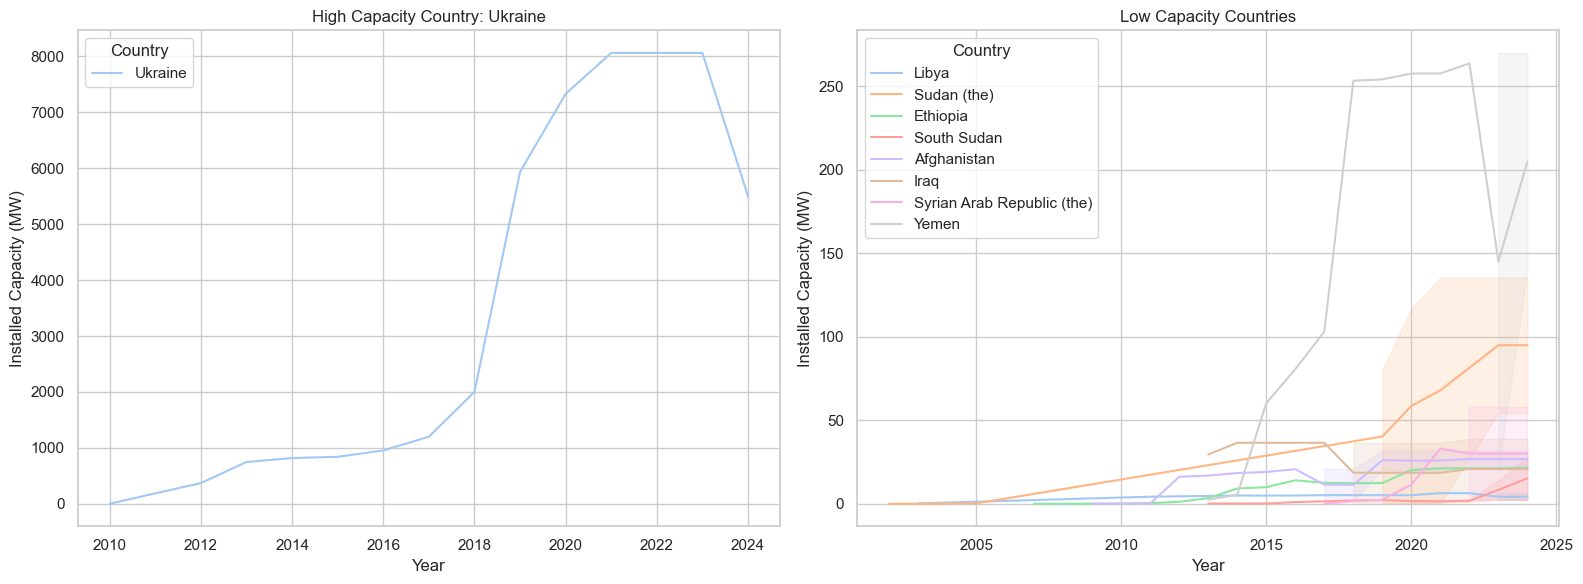

In [5]:
# 5.High vs Low Capacity
# Ukraine has much higher capacity than others, so we separate it
high_capacity_countries = ["Ukraine"]

# Getting all unique country names from our data
all_countries = solar_df["Country"].unique()

# Creating a list of countries that are NOT Ukraine (the low capacity ones)
low_capacity_countries = []
for country in all_countries:
    if country != "Ukraine":  # If it's not Ukraine
        low_capacity_countries.append(country)  # Add it to low capacity list

# Then creating two graphs side by side to see difference
fig, (left_graph, right_graph) = plt.subplots(1, 2, figsize=(16, 6))
# 1 = one row, 2 = two columns, figsize makes it wide enough for both

# The LEFT graph (for high capacity countries)
# Filter our data to only include Ukraine
ukraine_data = solar_df[solar_df["Country"] == "Ukraine"]

# Plotting Ukraine's data on the left graph
sns.lineplot(
    data=ukraine_data,
    x="Year",
    y="Electricity Installed Capacity (MW)",
    hue="Country",
    ax=left_graph,
)

# Adding labels to the left graph
left_graph.set_title("High Capacity Country: Ukraine")
left_graph.set_ylabel("Installed Capacity (MW)")
left_graph.set_xlabel("Year")

# The RIGHT graph (for low capacity countries)
# Filter our data to exclude Ukraine (keep all others)
other_countries_data = solar_df[solar_df["Country"] != "Ukraine"]

# Plotting all other countries 8 on the right graph
sns.lineplot(
    data=other_countries_data,
    x="Year",
    y="Electricity Installed Capacity (MW)",
    hue="Country",
    ax=right_graph,
)

# Add labels to the right graph
right_graph.set_title("Low Capacity Countries")
right_graph.set_ylabel("Installed Capacity (MW)")
right_graph.set_xlabel("Year")

plt.tight_layout()
plt.show()

# - Left graph: Ukraine's dramatic growth (large numbers)
# - Right graph: All other countries (smaller numbers, but now visible!)

**Key Finding:**  
 _Ukraine's solar energy_ capacity is dramatically higher than all other countries in the dataset, with over _8,000 MW_ by 2024 compared to less than _250 MW_ for any other country.   
 
 This 30-40x difference is so extreme that Ukraine must be analyzed separately from other countries (Libya, Syria, Sudan, Ethiopia, South Sudan, Afghanistan, Iraq, Yemen) to make meaningful comparisons, as Ukraine's exponential growth from 2016-2022 completely dominates the scale and obscures patterns in the remaining countries.

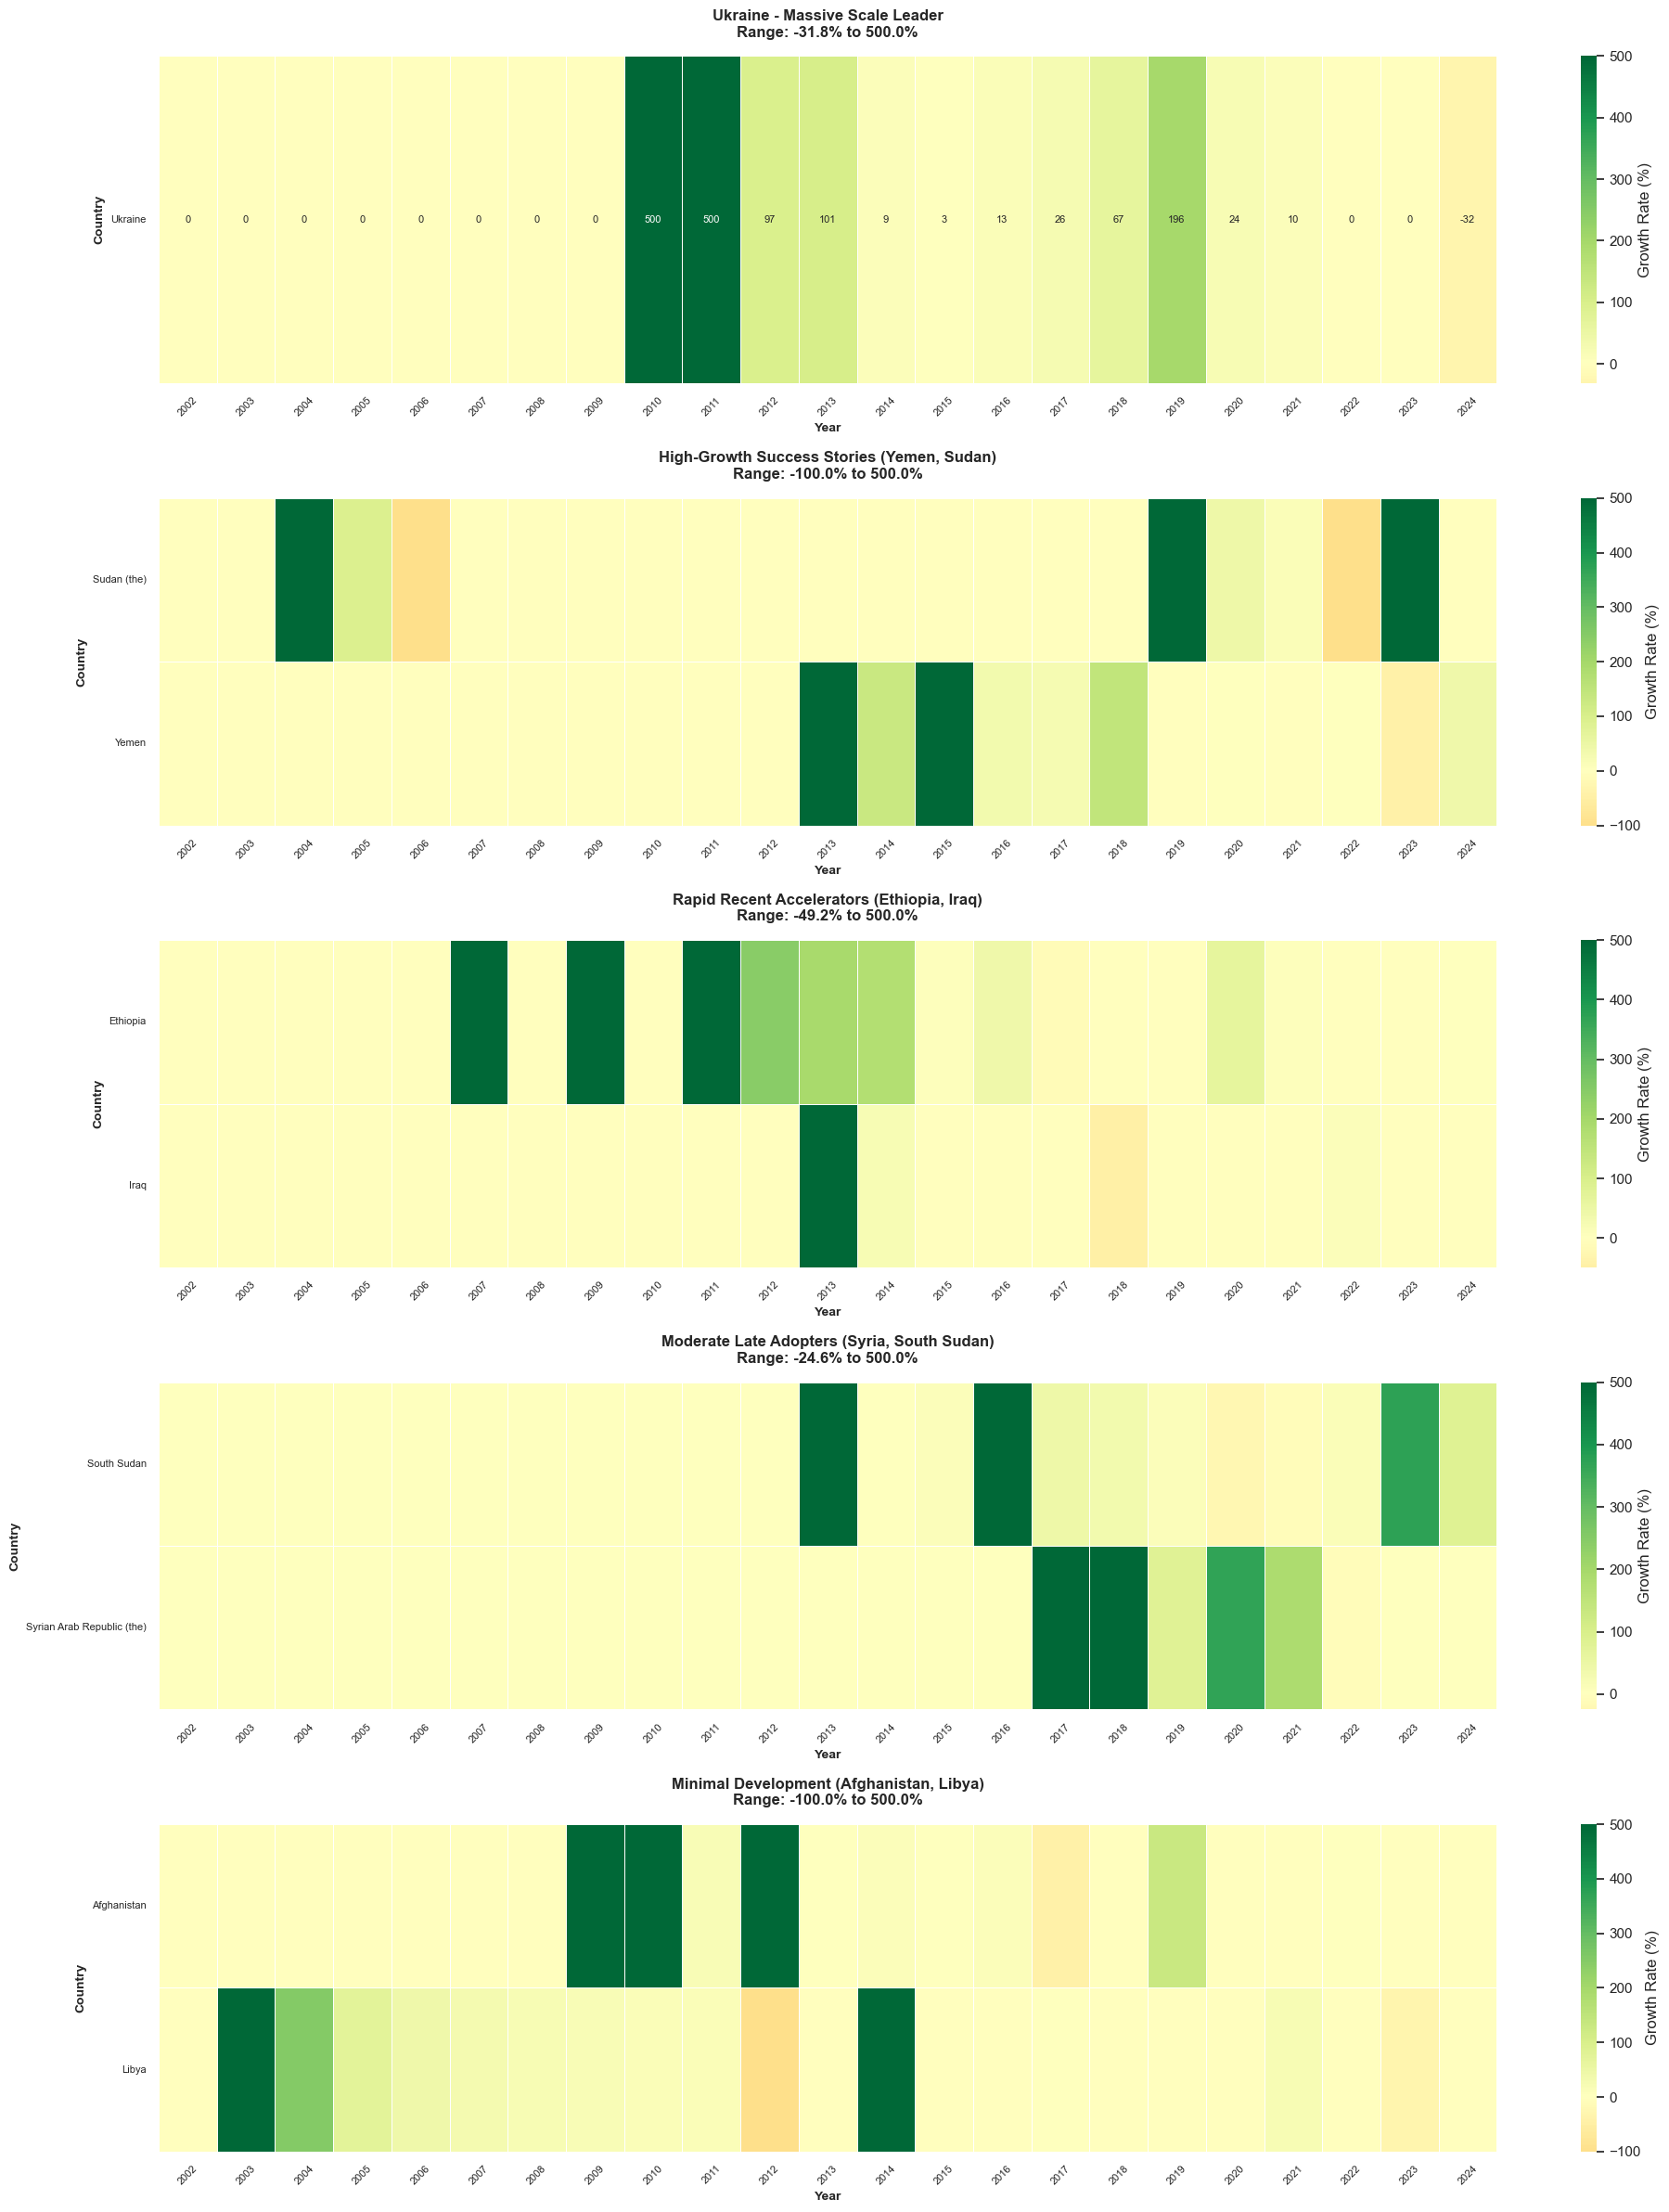

In [6]:
# 5. Heat map for countries with similar pattern
# Step 1: Prepare the data for heatmap format
heatmap_data = solar_df.pivot_table(
    index="Country",
    columns="Year",
    values="Electricity Installed Capacity (MW)",
    fill_value=0,
)


# Step 2: Calculate year-over-year growth rates
def calculate_growth_rates(data):
    growth_data = data.copy()
    growth_data.iloc[:, 0] = 0  # First year = 0% growth
    for country in growth_data.index:
        for i in range(1, len(growth_data.columns)):
            prev_year = growth_data.columns[i - 1]
            curr_year = growth_data.columns[i]
            prev_capacity = data.loc[country, prev_year]
            curr_capacity = data.loc[country, curr_year]
            if prev_capacity == 0:
                growth_data.loc[country, curr_year] = 500 if curr_capacity > 0 else 0
            else:
                growth_rate = ((curr_capacity - prev_capacity) / prev_capacity) * 100
                growth_data.loc[country, curr_year] = min(max(growth_rate, -100), 500)
    return growth_data


all_growth_data = calculate_growth_rates(heatmap_data)

# Step 3: Group countries by similar patterns
ukraine_growth = all_growth_data[all_growth_data.index == "Ukraine"]
group2_growth = all_growth_data[all_growth_data.index.isin(["Yemen", "Sudan (the)"])]
group3_growth = all_growth_data[all_growth_data.index.isin(["Ethiopia", "Iraq"])]
group4_growth = all_growth_data[
    all_growth_data.index.isin(["Syrian Arab Republic (the)", "South Sudan"])
]
group5_growth = all_growth_data[all_growth_data.index.isin(["Afghanistan", "Libya"])]

# Step 4: Plot heatmaps
fig, axes = plt.subplots(5, 1, figsize=(20, 24))

heatmap_params = {
    "cmap": "RdYlGn",
    "center": 0,
    "linewidths": 0.5,
    "linecolor": "white",
    "square": False,
    "fmt": ".0f",
}

sns.heatmap(
    ukraine_growth,
    annot=True,
    annot_kws={"fontsize": 8},
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[0],
    **heatmap_params,
)
axes[0].set_title(
    f"Ukraine - Massive Scale Leader\nRange: {ukraine_growth.min().min():.1f}% to {ukraine_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    group2_growth,
    annot=False,
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[1],
    **heatmap_params,
)
axes[1].set_title(
    f"High-Growth Success Stories (Yemen, Sudan)\nRange: {group2_growth.min().min():.1f}% to {group2_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    group3_growth,
    annot=False,
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[2],
    **heatmap_params,
)
axes[2].set_title(
    f"Rapid Recent Accelerators (Ethiopia, Iraq)\nRange: {group3_growth.min().min():.1f}% to {group3_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    group4_growth,
    annot=False,
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[3],
    **heatmap_params,
)
axes[3].set_title(
    f"Moderate Late Adopters (Syria, South Sudan)\nRange: {group4_growth.min().min():.1f}% to {group4_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    group5_growth,
    annot=False,
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[4],
    **heatmap_params,
)
axes[4].set_title(
    f"Minimal Development (Afghanistan, Libya)\nRange: {group5_growth.min().min():.1f}% to {group5_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

# Customize all axes
for ax in axes:
    ax.set_xlabel("Year", fontsize=10, fontweight="bold")
    ax.set_ylabel("Country", fontsize=10, fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    ax.tick_params(axis="y", rotation=0, labelsize=8)

plt.tight_layout()
plt.show()

**Key Findings:**

 **When Countries Started Building Solar Power**

 **Time Periods**
1. **2009-2010**: Ukraine and Afghanistan started big projects
2. **2004-2006**: Sudan began building solar power
3. **2018-2022**: Yemen and Iraq got serious about solar
4. **2020-2025**: Syria and South Sudan joined in recently

 **How Fast They Grew**

 **Growth Speed**
- **500% growth**: Means they built A LOT very quickly (like going from 1 to 5 solar farms)
- **Steady vs. Stop-and-Go**: Ukraine and Yemen kept building consistently; others built in short bursts then stopped
- **Negative growth**: Sometimes they had less solar power than before (maybe some broke down)

 **Three Waves of Countries**

 **The Waves**
1. **Early Starters (2004–2010)**: Sudan, Ukraine, Afghanistan & Ethiopia went first  
→ _These countries had the most time to grow solar but only Ukraine sustained it._
2. **Middle Joiners (2015–2018):** Syria, South Sudan joined later  
→ _Late to start, with minimal long-term growth._  
3.**Recent Joiners (2018–2025):** Yemen, Iraq are newest  
→ _Sharp increases in short time; future potential._
1. **Barely Tried:** Libya hardly built any solar  
→ _Very low adoption overall._

 **Main Point**
All countries can grow solar power really fast when they start (500% growth), but most countries only did it for a short time and then stopped. Ukraine was the only one that kept building solar power for many years, which is why they have so much more than everyone else.

Conflict Phase
active-conflict    577.227956
pre-conflict        51.992963
post-conflict       15.525667
Name: Electricity Installed Capacity (MW), dtype: float64


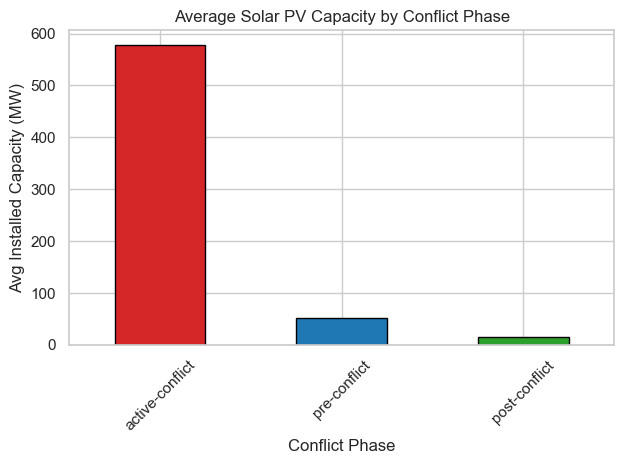

In [7]:
# 3. Average Solar Energy Capacity by Conflict Phase

avg_capacity_by_phase = (
    solar_df.groupby("Conflict Phase")["Electricity Installed Capacity (MW)"]
    .mean()
    .sort_values(ascending=False)
)

print(avg_capacity_by_phase)


colors = {
    "pre-conflict": "#1f77b4",  # blue
    "active-conflict": "#d62728",  # red
    "post-conflict": "#2ca02c",  # green
    "transitional": "#ff7f0e",  # orange (if used)
}

# Plot
avg_capacity_by_phase.plot(
    kind="bar",
    color=[colors[phase] for phase in avg_capacity_by_phase.index],
    edgecolor="black",
)

plt.title("Average Solar PV Capacity by Conflict Phase")
plt.ylabel("Avg Installed Capacity (MW)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

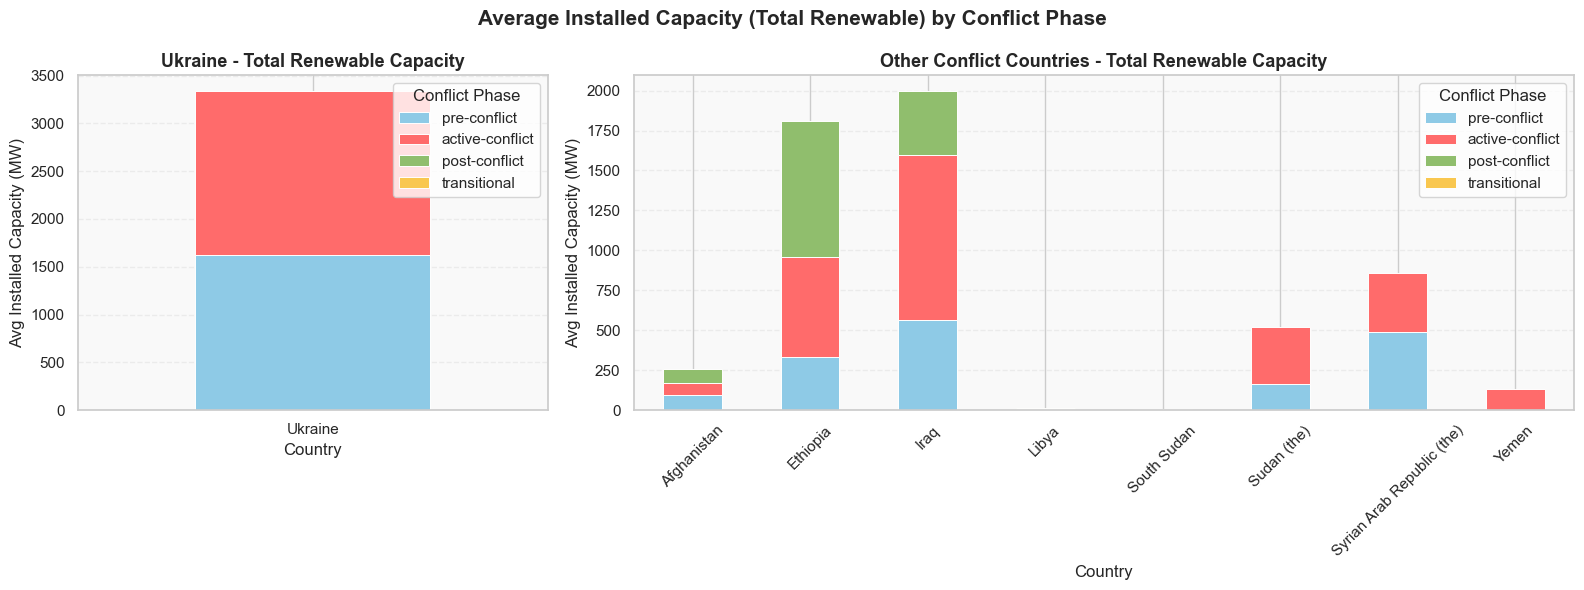

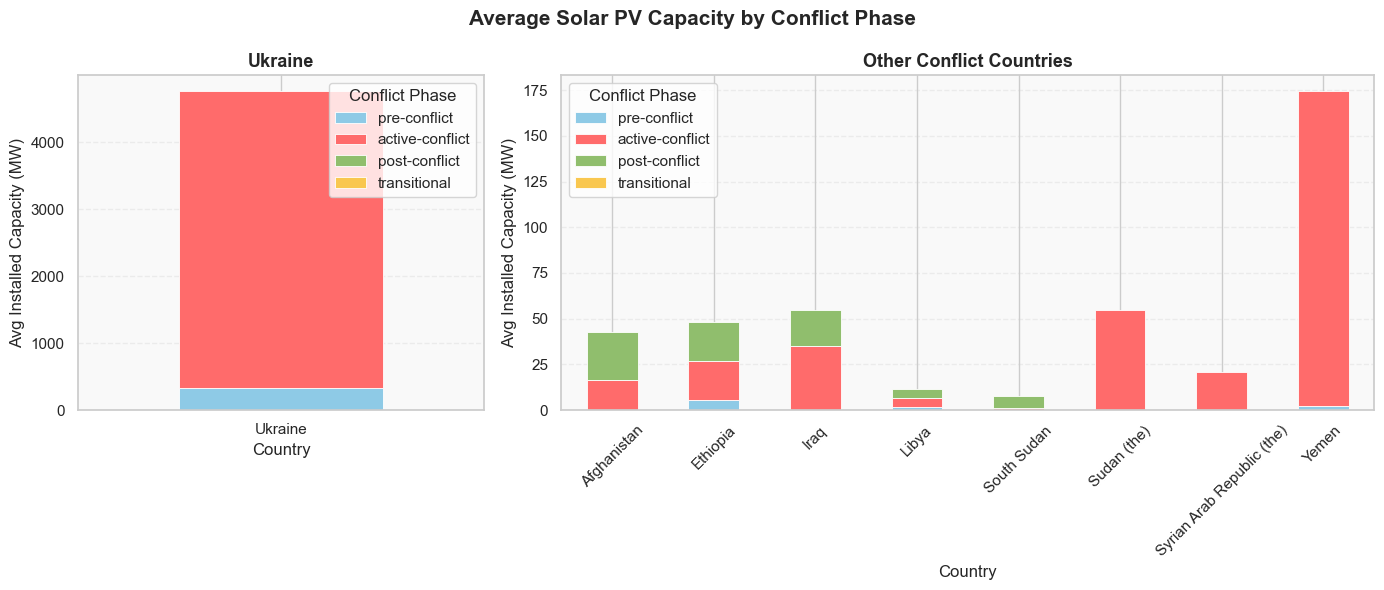

In [8]:
# 4.Average Installed Capacity (Total Renewable) by Conflict Phase

# === Filter for Total Renewable energy only ===
total_renewable_df = df[df["RE or Non-RE"].str.lower() == "total renewable"]

# === Define consistent conflict phase color palette ===
colors = {
    "pre-conflict": "#8ecae6",
    "active-conflict": "#ff6b6b",
    "post-conflict": "#90be6d",
    "transitional": "#f9c74f",
}

# === Split into Ukraine and Others ===
ukraine_df = total_renewable_df[total_renewable_df["Country"] == "Ukraine"]
others_df = total_renewable_df[total_renewable_df["Country"] != "Ukraine"]

# === Group by Country and Conflict Phase ===
ukraine_grouped = (
    ukraine_df.groupby(["Country", "Conflict Phase"])[
        "Electricity Installed Capacity (MW)"
    ]
    .mean()
    .unstack(fill_value=0)
    .reindex(
        columns=["pre-conflict", "active-conflict", "post-conflict", "transitional"],
        fill_value=0,
    )
)

others_grouped = (
    others_df.groupby(["Country", "Conflict Phase"])[
        "Electricity Installed Capacity (MW)"
    ]
    .mean()
    .unstack(fill_value=0)
    .reindex(
        columns=["pre-conflict", "active-conflict", "post-conflict", "transitional"],
        fill_value=0,
    )
)

# === Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={"width_ratios": [1, 2]})

# Plot Ukraine
ukraine_grouped.plot(
    kind="bar",
    stacked=True,
    color=[colors[phase] for phase in ukraine_grouped.columns],
    edgecolor="white",
    linewidth=0.7,
    ax=axes[0],
)
axes[0].set_title("Ukraine - Total Renewable Capacity", fontsize=13, weight="bold")
axes[0].set_ylabel("Avg Installed Capacity (MW)")
axes[0].tick_params(axis="x", rotation=0)
axes[0].legend(title="Conflict Phase")
axes[0].grid(axis="y", linestyle="--", alpha=0.3)
axes[0].set_facecolor("#f9f9f9")

# Plot Other Countries
others_grouped.plot(
    kind="bar",
    stacked=True,
    color=[colors[phase] for phase in others_grouped.columns],
    edgecolor="white",
    linewidth=0.7,
    ax=axes[1],
)
axes[1].set_title(
    "Other Conflict Countries - Total Renewable Capacity", fontsize=13, weight="bold"
)
axes[1].set_ylabel("Avg Installed Capacity (MW)")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend(title="Conflict Phase")
axes[1].grid(axis="y", linestyle="--", alpha=0.3)
axes[1].set_facecolor("#f9f9f9")

# Overall Title
fig.suptitle(
    "Average Installed Capacity (Total Renewable) by Conflict Phase",
    fontsize=15,
    weight="bold",
)
plt.tight_layout()
plt.show()

# --
#5. Average Solar PV Capacity by Conflict Phase (Stacked Bar Chart)

# Define color palette
colors = {
    "pre-conflict": "#8ecae6",  # light blue
    "active-conflict": "#ff6b6b",  # coral red
    "post-conflict": "#90be6d",  # green
    "transitional": "#f9c74f",  # orange-yellow
}

# === Separate Ukraine and Others ===
ukraine_df = solar_df[solar_df["Country"] == "Ukraine"]
other_df = solar_df[solar_df["Country"] != "Ukraine"]

# === Group: Ukraine by phase ===
ukraine_avg = (
    ukraine_df.groupby(["Country", "Conflict Phase"])[
        "Electricity Installed Capacity (MW)"
    ]
    .mean()
    .unstack(fill_value=0)
    .reindex(
        columns=["pre-conflict", "active-conflict", "post-conflict", "transitional"]
    )
)

# === Group: Other countries by phase ===
other_grouped = (
    other_df.groupby(["Country", "Conflict Phase"])[
        "Electricity Installed Capacity (MW)"
    ]
    .mean()
    .unstack(fill_value=0)
    .reindex(
        columns=["pre-conflict", "active-conflict", "post-conflict", "transitional"]
    )
)

# === Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios": [1, 2]})

# --- Plot 1: Ukraine (stacked) ---
ukraine_avg.plot(
    kind="bar",
    stacked=True,
    color=[colors[phase] for phase in ukraine_avg.columns],
    edgecolor="white",
    linewidth=0.6,
    ax=axes[0],
)
axes[0].set_title("Ukraine", fontsize=13, weight="bold")
axes[0].set_ylabel("Avg Installed Capacity (MW)")
axes[0].tick_params(axis="x", rotation=0)
axes[0].legend(title="Conflict Phase")
axes[0].grid(axis="y", linestyle="--", alpha=0.3)
axes[0].set_facecolor("#f9f9f9")

# --- Plot 2: Other Conflict Countries (stacked) ---
other_grouped.plot(
    kind="bar",
    stacked=True,
    color=[colors[phase] for phase in other_grouped.columns],
    edgecolor="white",
    linewidth=0.6,
    ax=axes[1],
)
axes[1].set_title("Other Conflict Countries", fontsize=13, weight="bold")
axes[1].set_ylabel("Avg Installed Capacity (MW)")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend(title="Conflict Phase")
axes[1].grid(axis="y", linestyle="--", alpha=0.3)
axes[1].set_facecolor("#f9f9f9")

# Overall layout
fig.suptitle("Average Solar PV Capacity by Conflict Phase", fontsize=15, weight="bold")
plt.tight_layout()
plt.show()

Analysis of Solar Capacity by Conflict Phase
Countries with solar data: 9
Available phases: ['active-conflict', 'post-conflict', 'pre-conflict', 'transitional']

Iraq:
  pre-conflict: 0.0 MW (2000-2002)
  active-conflict: 175.5 MW (2003-2017)
  post-conflict: 273.0 MW (2018-2024)

Afghanistan:
  pre-conflict: 0.0 MW (2000-2000)
  active-conflict: 292.0 MW (2001-2021)
  post-conflict: 160.4 MW (2022-2024)

Libya:
  pre-conflict: 15.6 MW (2000-2010)
  active-conflict: 39.3 MW (2011-2020)
  post-conflict: 29.3 MW (2021-2024)

Yemen:
  pre-conflict: 2.4 MW (2000-2013)
  active-conflict: 2236.0 MW (2014-2024)

Ukraine:
  pre-conflict: 1310.7 MW (2000-2013)
  active-conflict: 48770.4 MW (2014-2024)

Ethiopia:
  pre-conflict: 75.1 MW (2000-2019)
  active-conflict: 62.6 MW (2020-2022)
  post-conflict: 42.7 MW (2023-2024)

South Sudan:
  pre-conflict: 0.0 MW (2000-2011)
  active-conflict: 9.9 MW (2013-2020)
  post-conflict: 53.4 MW (2021-2024)

Sudan (the):
  pre-conflict: 0.0 MW (2000-2002)
  

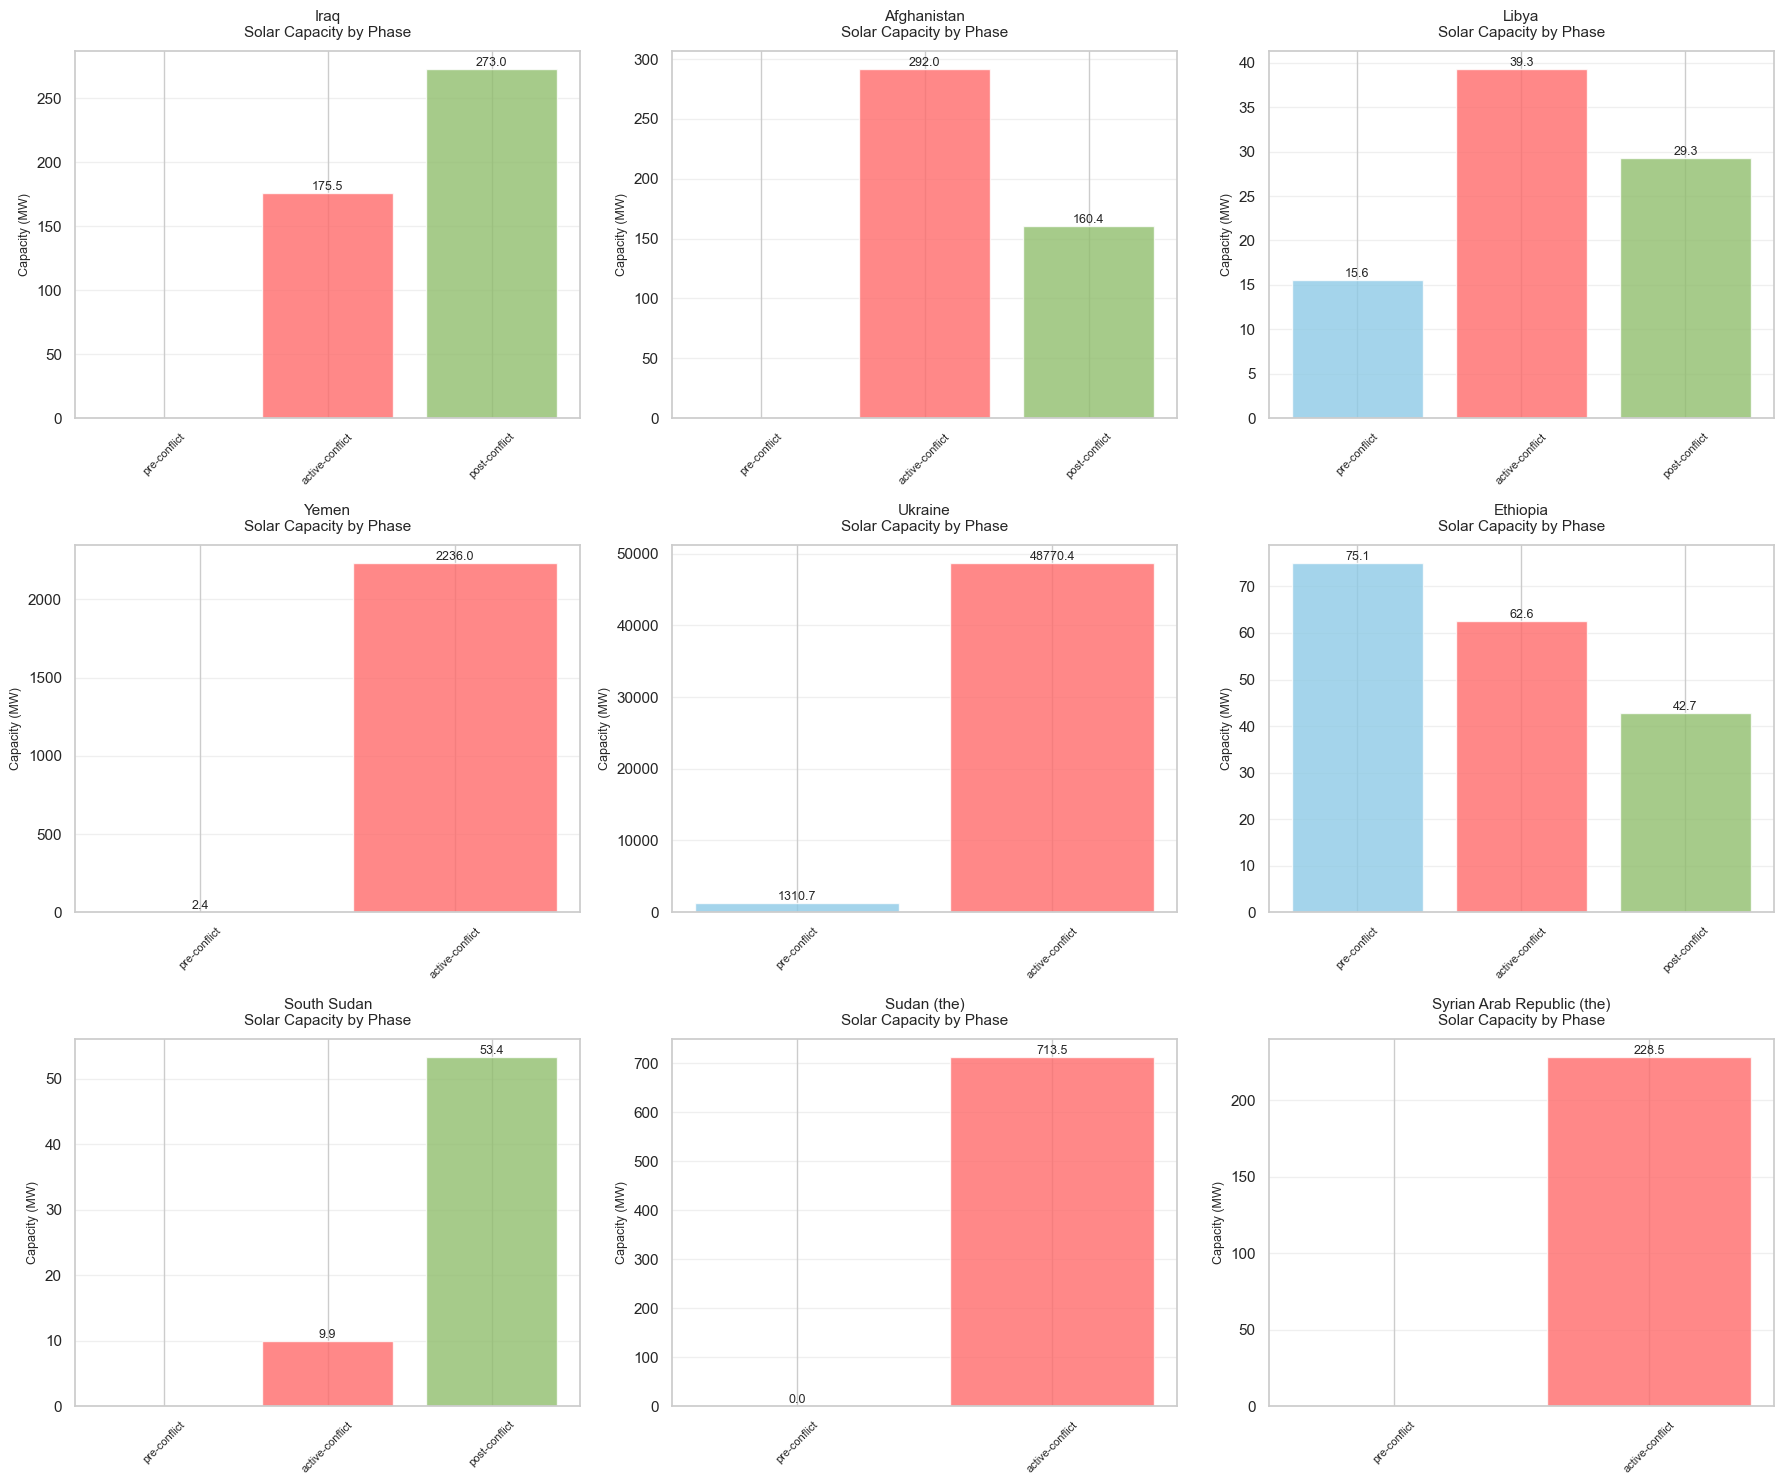


SUMMARY ANALYSIS
Active-Conflict: 52527.7 MW total, 9 countries, 5836.4 MW average
Post-Conflict: 558.9 MW total, 5 countries, 111.8 MW average
Pre-Conflict: 1403.8 MW total, 5 countries, 280.8 MW average


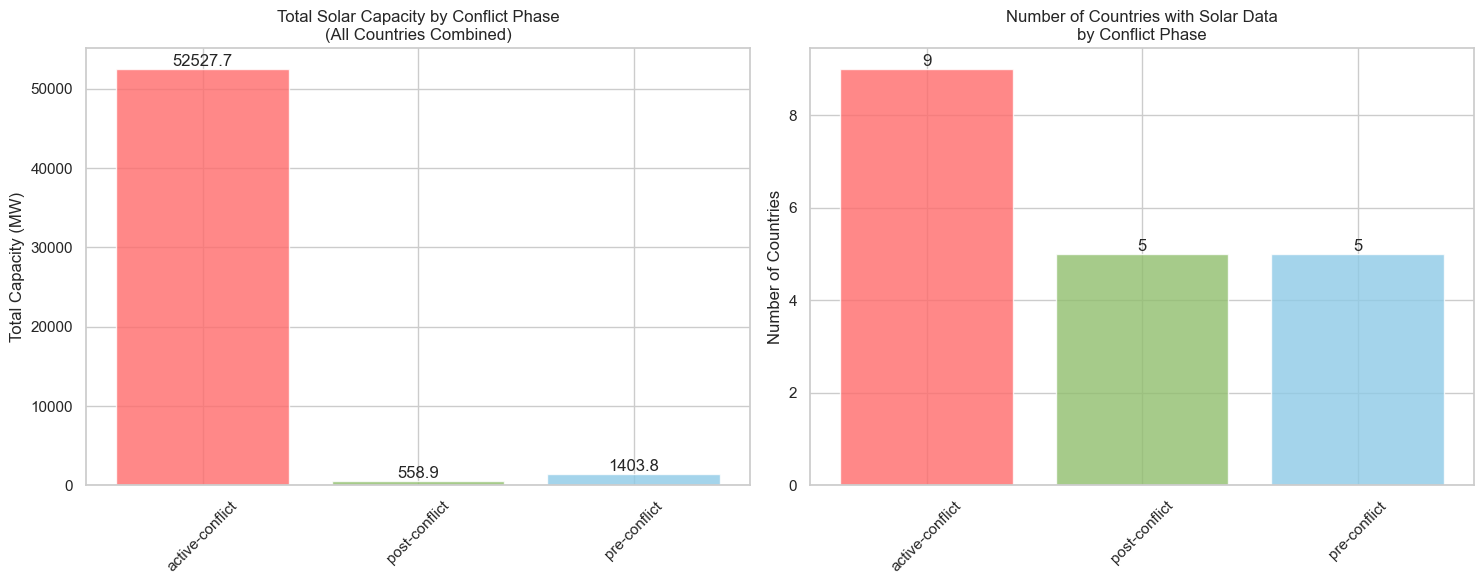

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Your conflict phase definitions
conflict_phases = {
    "Iraq": {
        "pre-conflict": range(2000, 2003),  # 2000–2002
        "active-conflict": range(2003, 2018),  # 2003–2017
        "post-conflict": range(2018, 2025),  # 2018–2024
    },
    "Afghanistan": {
        "pre-conflict": range(2000, 2001),  # 2000
        "active-conflict": range(2001, 2022),  # 2001–2021
        "post-conflict": range(2022, 2025),  # 2022–2024
    },
    "Libya": {
        "pre-conflict": range(2000, 2011),  # 2000–2010
        "active-conflict": [2011] + list(range(2014, 2021)),  # 2011, 2014–2020
        "transitional": range(2012, 2014),  # 2012–2013
        "post-conflict": range(2021, 2025),  # 2021–2024
    },
    "Yemen": {
        "pre-conflict": range(2000, 2014),  # 2000–2013
        "active-conflict": range(2014, 2025),  # 2014–2024
    },
    "Ukraine": {
        "pre-conflict": range(2000, 2014),  # 2000–2013
        "active-conflict": range(2014, 2025),  # 2014–2024
    },
    "Ethiopia": {
        "pre-conflict": range(2000, 2020),  # 2000–2019
        "active-conflict": range(2020, 2023),  # 2020–2022
        "post-conflict": range(2023, 2025),  # 2023–2024
    },
    "South Sudan": {
        "pre-conflict": range(2000, 2012),  # 2000–2011
        "active-conflict": range(2013, 2021),  # 2013–2020
        "post-conflict": range(2021, 2025),  # 2021–2024
        "transitional": [2012],  # Independence year
    },
    "Sudan (the)": {
        "pre-conflict": range(2000, 2003),  # 2000–2002
        "active-conflict": list(range(2003, 2006))
        + list(range(2019, 2022))
        + list(range(2023, 2025)),
        "transitional": list(range(2006, 2019)) + [2022],
    },
    "Syrian Arab Republic (the)": {
        "pre-conflict": range(2000, 2011),  # 2000–2010
        "active-conflict": range(2011, 2025),  # 2011–2024 (ongoing)
    },
}

# Filter to only solar type if needed
if "Type" in solar_df.columns:
    solar_df = solar_df[solar_df["Type"].str.lower() == "solar"]

# Define colors for each phase
phase_colors = {
    "pre-conflict": "#8ecae6",  # light blue
    "active-conflict": "#ff6b6b",  # coral red
    "post-conflict": "#90be6d",  # green
    "transitional": "#f9c74f",  # orange-yellow
}

# Get all unique phases from the definitions
all_phases = set()
for country_phases in conflict_phases.values():
    all_phases.update(country_phases.keys())
all_phases = sorted(list(all_phases))

print("Analysis of Solar Capacity by Conflict Phase")
print("=" * 50)

# Calculate totals per country per phase
phase_totals = (
    solar_df.groupby(["Country", "Conflict Phase"])[
        "Electricity Installed Capacity (MW)"
    ]
    .sum()
    .unstack(fill_value=0)
)

# Get countries that are in our conflict_phases dictionary
conflict_countries = list(conflict_phases.keys())
available_countries = [c for c in conflict_countries if c in phase_totals.index]

print(f"Countries with solar data: {len(available_countries)}")
print(f"Available phases: {all_phases}")
print()

# Create the visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

# Plot each country
for i, country in enumerate(available_countries):
    if i >= 9:  # Only show first 9 countries
        break

    ax = axes[i]

    # Get the phases this country actually has data for
    country_data = phase_totals.loc[country]

    # Get phases defined for this country
    defined_phases = list(conflict_phases[country].keys())

    # Only plot phases that exist in both the definition and the data
    phases_to_plot = [p for p in defined_phases if p in country_data.index]
    values = [country_data[p] for p in phases_to_plot]
    colors = [phase_colors[p] for p in phases_to_plot]

    # Create bar chart
    bars = ax.bar(phases_to_plot, values, color=colors, alpha=0.8)

    # Add value labels on bars
    for bar, val in zip(bars, values):
        if val > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{val:.1f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

    # Customize the plot
    ax.set_title(f"{country}\nSolar Capacity by Phase", fontsize=11, pad=10)
    ax.set_ylabel("Capacity (MW)", fontsize=9)
    ax.tick_params(axis="x", rotation=45, labelsize=8)

    # Add grid for easier reading
    ax.grid(True, alpha=0.3, axis="y")

    # Print summary for this country
    print(f"{country}:")
    for phase in phases_to_plot:
        years = conflict_phases[country][phase]
        if isinstance(years, range):
            year_str = f"{years.start}-{years.stop - 1}"
        else:
            year_str = f"{min(years)}-{max(years)}" if len(years) > 1 else str(years[0])
        print(f"  {phase}: {country_data[phase]:.1f} MW ({year_str})")
    print()

# Hide unused subplots
for i in range(len(available_countries), 9):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Summary analysis
print("\n" + "=" * 50)
print("SUMMARY ANALYSIS")
print("=" * 50)

# Total capacity by phase across all countries
phase_summary = {}
for phase in all_phases:
    total = 0
    countries_with_phase = 0
    for country in available_countries:
        if phase in phase_totals.columns and country in phase_totals.index:
            capacity = phase_totals.loc[country, phase]
            if capacity > 0:
                total += capacity
                countries_with_phase += 1
    phase_summary[phase] = {"total": total, "countries": countries_with_phase}

for phase, data in phase_summary.items():
    if data["total"] > 0:
        avg = data["total"] / data["countries"] if data["countries"] > 0 else 0
        print(
            f"{phase.title()}: {data['total']:.1f} MW total, {data['countries']} countries, {avg:.1f} MW average"
        )

# Create summary chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Total capacity by phase
phases_with_data = [p for p in all_phases if phase_summary[p]["total"] > 0]
totals = [phase_summary[p]["total"] for p in phases_with_data]
colors = [phase_colors[p] for p in phases_with_data]

bars1 = ax1.bar(phases_with_data, totals, color=colors, alpha=0.8)
ax1.set_title(
    "Total Solar Capacity by Conflict Phase\n(All Countries Combined)", fontsize=12
)
ax1.set_ylabel("Total Capacity (MW)")
ax1.tick_params(axis="x", rotation=45)

for bar, val in zip(bars1, totals):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{val:.1f}",
        ha="center",
        va="bottom",
    )

# Number of countries by phase
country_counts = [phase_summary[p]["countries"] for p in phases_with_data]
bars2 = ax2.bar(phases_with_data, country_counts, color=colors, alpha=0.8)
ax2.set_title("Number of Countries with Solar Data\nby Conflict Phase", fontsize=12)
ax2.set_ylabel("Number of Countries")
ax2.tick_params(axis="x", rotation=45)

for bar, val in zip(bars2, country_counts):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{val}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()


SOLAR CAPACITY IMPACT ANALYSIS

Summary Table:
    Country  Pre-Conflict Avg (MW)  Conflict Avg (MW)  Post-Conflict Avg (MW)  Trend
       Iraq                    0.0               35.1                    39.0 Growth
Afghanistan                    0.0               22.5                    53.5 Growth
      Libya                    2.0                4.9                     7.3 Growth
      Yemen                    2.4              203.3                     NaN Growth
    Ukraine                  327.7             4433.7                     NaN Growth
   Ethiopia                    5.8               20.9                    21.4 Growth
South Sudan                    0.0                1.2                    13.3 Growth
      Sudan                    0.0               89.2                     0.0 Growth
      Syria                    0.0               28.6                     NaN Growth


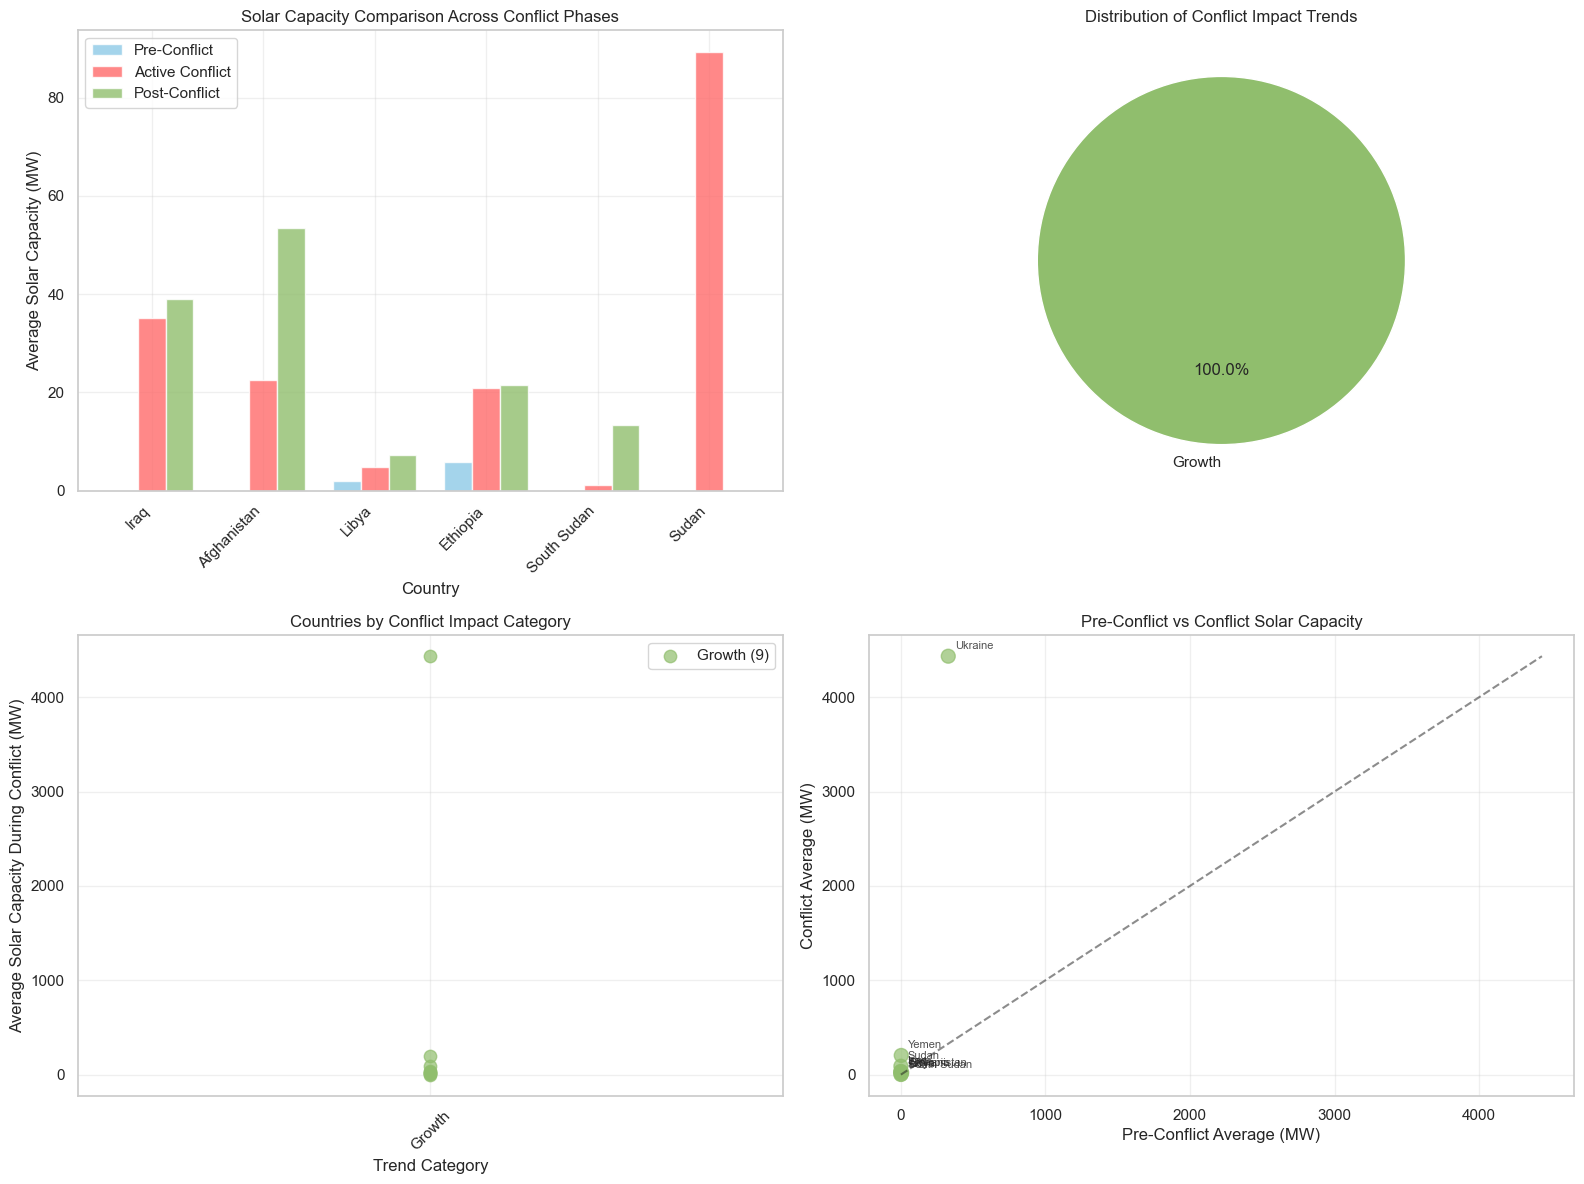


DETAILED ANALYSIS

🔴 COUNTRIES WITH CONSISTENT DROP/COLLAPSE:

🟡 COUNTRIES WITH NO SIGNIFICANT CHANGE:

🟢 COUNTRIES WITH SURPRISING GROWTH DURING CONFLICT:
  • Iraq: 0.0 → 35.1 MW (Growth)
  • Afghanistan: 0.0 → 22.5 MW (Growth)
  • Libya: 2.0 → 4.9 MW (Growth)
  • Yemen: 2.4 → 203.3 MW (Growth)
  • Ukraine: 327.7 → 4433.7 MW (Growth)
  • Ethiopia: 5.8 → 20.9 MW (Growth)
  • South Sudan: 0.0 → 1.2 MW (Growth)
  • Sudan: 0.0 → 89.2 MW (Growth)
  • Syria: 0.0 → 28.6 MW (Growth)

📊 SUMMARY STATISTICS:
Total countries analyzed: 9
Countries showing growth during conflict: 9
Countries showing decline during conflict: 0
Countries with post-conflict data: 6


In [10]:


# Your conflict phase definitions
conflict_phases = {
    "Iraq": {
        "pre-conflict": range(2000, 2003),
        "active-conflict": range(2003, 2018),
        "post-conflict": range(2018, 2025),
    },
    "Afghanistan": {
        "pre-conflict": range(2000, 2001),
        "active-conflict": range(2001, 2022),
        "post-conflict": range(2022, 2025),
    },
    "Libya": {
        "pre-conflict": range(2000, 2011),
        "active-conflict": [2011] + list(range(2014, 2021)),
        "transitional": range(2012, 2014),
        "post-conflict": range(2021, 2025),
    },
    "Yemen": {
        "pre-conflict": range(2000, 2014),
        "active-conflict": range(2014, 2025),
    },
    "Ukraine": {
        "pre-conflict": range(2000, 2014),
        "active-conflict": range(2014, 2025),
    },
    "Ethiopia": {
        "pre-conflict": range(2000, 2020),
        "active-conflict": range(2020, 2023),
        "post-conflict": range(2023, 2025),
    },
    "South Sudan": {
        "pre-conflict": range(2000, 2012),
        "active-conflict": range(2013, 2021),
        "post-conflict": range(2021, 2025),
        "transitional": [2012],
    },
    "Sudan (the)": {
        "pre-conflict": range(2000, 2003),
        "active-conflict": list(range(2003, 2006))
        + list(range(2019, 2022))
        + list(range(2023, 2025)),
        "transitional": list(range(2006, 2019)) + [2022],
    },
    "Syrian Arab Republic (the)": {
        "pre-conflict": range(2000, 2011),
        "active-conflict": range(2011, 2025),
    },
}

# Filter to only solar type if needed
if "Type" in solar_df.columns:
    solar_df = solar_df[solar_df["Type"].str.lower() == "solar"]

# Calculate annual totals per country
annual_totals = (
    solar_df.groupby(["Country", "Year"])[
        "Electricity Installed Capacity (MW)"
    ]
    .sum()
    .reset_index()
)

# Function to calculate average capacity per phase
def calculate_phase_averages(country, data):
    """Calculate average solar capacity for each phase of a country"""
    country_data = data[data["Country"] == country]
    
    if country not in conflict_phases:
        return {}
    
    phase_averages = {}
    
    for phase, years in conflict_phases[country].items():
        # Convert years to list if it's a range
        if isinstance(years, range):
            year_list = list(years)
        else:
            year_list = years if isinstance(years, list) else [years]
        
        # Get data for this phase
        phase_data = country_data[country_data["Year"].isin(year_list)]
        
        if not phase_data.empty:
            phase_averages[phase] = phase_data["Electricity Installed Capacity (MW)"].mean()
        else:
            phase_averages[phase] = 0.0
    
    return phase_averages

# Function to determine trend
def determine_trend(pre, conflict, post):
    """Determine the trend based on pre, conflict, and post values"""
    if post is None or np.isnan(post):
        if conflict <= pre * 0.5:
            return "Collapse"
        elif conflict <= pre * 0.8:
            return "Drop"
        elif conflict >= pre * 1.2:
            return "Growth"
        else:
            return "Stable"
    else:
        # Compare all three phases
        if conflict <= pre * 0.5:
            if post > conflict * 1.5:
                return "Recovery"
            else:
                return "Collapse"
        elif conflict <= pre * 0.8:
            if post > pre:
                return "Recovery"
            else:
                return "Drop"
        elif conflict >= pre * 1.2:
            return "Growth"
        else:
            if post > pre * 1.2:
                return "Recovery"
            else:
                return "Stable"

# Calculate averages for all countries
results = []
conflict_countries = list(conflict_phases.keys())

for country in conflict_countries:
    phase_averages = calculate_phase_averages(country, annual_totals)
    
    pre = phase_averages.get("pre-conflict", 0)
    conflict = phase_averages.get("active-conflict", 0)
    post = phase_averages.get("post-conflict", None)
    transitional = phase_averages.get("transitional", None)
    
    # Use transitional as post if post doesn't exist
    if post is None or post == 0:
        post = transitional
    
    trend = determine_trend(pre, conflict, post)
    
    results.append({
        "Country": country,
        "Pre-Conflict Avg (MW)": pre,
        "Conflict Avg (MW)": conflict,
        "Post-Conflict Avg (MW)": post,
        "Trend": trend
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Clean up country names for display
results_df["Country"] = results_df["Country"].str.replace(" (the)", "").str.replace("Syrian Arab Republic", "Syria")

# Sort by trend categories
trend_order = ["Growth", "Recovery", "Stable", "Drop", "Collapse"]
results_df["Trend_Order"] = results_df["Trend"].map({trend: i for i, trend in enumerate(trend_order)})
results_df = results_df.sort_values("Trend_Order").drop("Trend_Order", axis=1)

# Round the averages
results_df["Pre-Conflict Avg (MW)"] = results_df["Pre-Conflict Avg (MW)"].round(1)
results_df["Conflict Avg (MW)"] = results_df["Conflict Avg (MW)"].round(1)
results_df["Post-Conflict Avg (MW)"] = results_df["Post-Conflict Avg (MW)"].round(1)

# Display the table
print("SOLAR CAPACITY IMPACT ANALYSIS")
print("=" * 60)
print("\nSummary Table:")
print(results_df.to_string(index=False))

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparison bar chart
countries_with_all_phases = results_df[results_df["Post-Conflict Avg (MW)"].notna()]
if not countries_with_all_phases.empty:
    x = np.arange(len(countries_with_all_phases))
    width = 0.25
    
    ax1.bar(x - width, countries_with_all_phases["Pre-Conflict Avg (MW)"], width, 
            label='Pre-Conflict', color='#8ecae6', alpha=0.8)
    ax1.bar(x, countries_with_all_phases["Conflict Avg (MW)"], width, 
            label='Active Conflict', color='#ff6b6b', alpha=0.8)
    ax1.bar(x + width, countries_with_all_phases["Post-Conflict Avg (MW)"], width, 
            label='Post-Conflict', color='#90be6d', alpha=0.8)
    
    ax1.set_xlabel('Country')
    ax1.set_ylabel('Average Solar Capacity (MW)')
    ax1.set_title('Solar Capacity Comparison Across Conflict Phases')
    ax1.set_xticks(x)
    ax1.set_xticklabels(countries_with_all_phases["Country"], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# 2. Trend distribution
trend_counts = results_df["Trend"].value_counts()
colors = ['#90be6d', '#8ecae6', '#ffd166', '#ff6b6b', '#d62728']
ax2.pie(trend_counts.values, labels=trend_counts.index, autopct='%1.1f%%', 
        colors=colors[:len(trend_counts)], startangle=90)
ax2.set_title('Distribution of Conflict Impact Trends')

# 3. Countries by trend category
trend_colors = {"Growth": "#90be6d", "Recovery": "#8ecae6", "Stable": "#ffd166", 
                "Drop": "#ff6b6b", "Collapse": "#d62728"}

for i, (trend, group) in enumerate(results_df.groupby("Trend")):
    ax3.scatter([i] * len(group), group["Conflict Avg (MW)"], 
               color=trend_colors.get(trend, 'gray'), s=80, alpha=0.7, 
               label=f"{trend} ({len(group)})")

ax3.set_xlabel('Trend Category')
ax3.set_ylabel('Average Solar Capacity During Conflict (MW)')
ax3.set_title('Countries by Conflict Impact Category')
ax3.set_xticks(range(len(results_df["Trend"].unique())))
ax3.set_xticklabels(results_df["Trend"].unique(), rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Before vs During Conflict scatter
ax4.scatter(results_df["Pre-Conflict Avg (MW)"], results_df["Conflict Avg (MW)"], 
           c=[trend_colors.get(trend, 'gray') for trend in results_df["Trend"]], 
           s=100, alpha=0.7)

# Add diagonal line for reference (no change)
max_val = max(results_df["Pre-Conflict Avg (MW)"].max(), results_df["Conflict Avg (MW)"].max())
ax4.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='No Change')

ax4.set_xlabel('Pre-Conflict Average (MW)')
ax4.set_ylabel('Conflict Average (MW)')
ax4.set_title('Pre-Conflict vs Conflict Solar Capacity')
ax4.grid(True, alpha=0.3)

# Add country labels
for i, row in results_df.iterrows():
    ax4.annotate(row["Country"], (row["Pre-Conflict Avg (MW)"], row["Conflict Avg (MW)"]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "=" * 60)
print("DETAILED ANALYSIS")
print("=" * 60)

print("\n🔴 COUNTRIES WITH CONSISTENT DROP/COLLAPSE:")
declining = results_df[results_df["Trend"].isin(["Drop", "Collapse"])]
for _, row in declining.iterrows():
    print(f"  • {row['Country']}: {row['Pre-Conflict Avg (MW)']} → {row['Conflict Avg (MW)']} MW ({row['Trend']})")

print("\n🟡 COUNTRIES WITH NO SIGNIFICANT CHANGE:")
stable = results_df[results_df["Trend"] == "Stable"]
for _, row in stable.iterrows():
    print(f"  • {row['Country']}: {row['Pre-Conflict Avg (MW)']} → {row['Conflict Avg (MW)']} MW (Stable)")

print("\n🟢 COUNTRIES WITH SURPRISING GROWTH DURING CONFLICT:")
growth = results_df[results_df["Trend"].isin(["Growth", "Recovery"])]
for _, row in growth.iterrows():
    if row["Conflict Avg (MW)"] > row["Pre-Conflict Avg (MW)"]:
        print(f"  • {row['Country']}: {row['Pre-Conflict Avg (MW)']} → {row['Conflict Avg (MW)']} MW ({row['Trend']})")

print(f"\n📊 SUMMARY STATISTICS:")
print(f"Total countries analyzed: {len(results_df)}")
print(f"Countries showing growth during conflict: {len(results_df[results_df['Conflict Avg (MW)'] > results_df['Pre-Conflict Avg (MW)']])}")
print(f"Countries showing decline during conflict: {len(results_df[results_df['Conflict Avg (MW)'] < results_df['Pre-Conflict Avg (MW)']])}")
print(f"Countries with post-conflict data: {len(results_df[results_df['Post-Conflict Avg (MW)'].notna()])}")

Solar Capacity Impact Analysis by Conflict Phase (Excluding Ukraine)
Analyzing 8 countries with solar data

SUMMARY TABLE: Solar Capacity Impact by Conflict Phase
Country                   Pre-Conflict Conflict     Post-Conflict Trend       
---------------------------------------------------------------------------
Iraq                      0.0          11.7         39.0         Recovery    
Afghanistan               0.0          13.9         53.5         Recovery    
Libya                     1.4          4.9          7.3          Increased   
Yemen                     0.2          203.3        0.0          Increased   
Ethiopia                  3.8          20.9         21.4         Increased   
South Sudan               0.0          1.2          13.3         Recovery    
Sudan (the)               0.0          89.2         0.0          Increased   
Syrian Arab Republic (th  0.0          16.3         0.0          No Data     

ANALYSIS BY TREND CATEGORY

RECOVERY (3 countries):
  • I

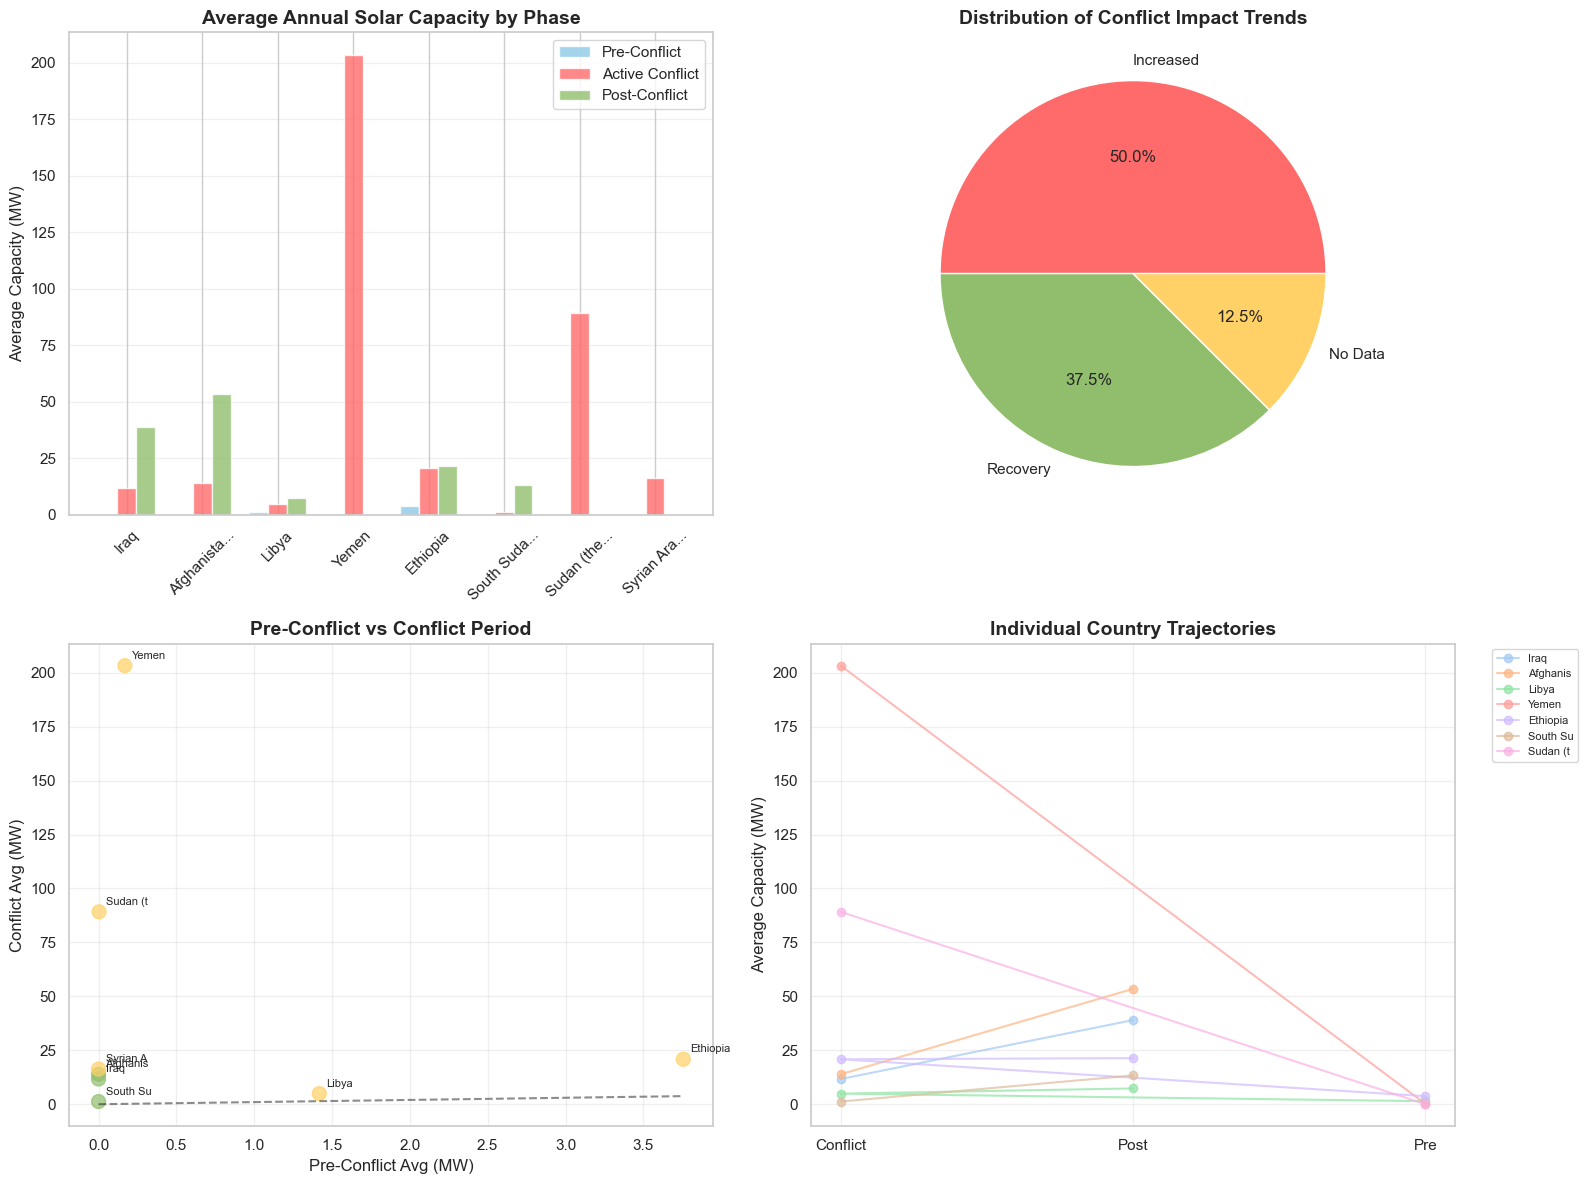


SEPARATE ANALYSIS: UKRAINE
Ukraine Solar Capacity Analysis:
  Pre-Conflict (2000-2013): 93.6 MW average annually
  Active Conflict (2014-2024): 4433.7 MW average annually
  Change during conflict: +4635.7%
  Trend: INCREASED - Remarkable growth despite ongoing conflict


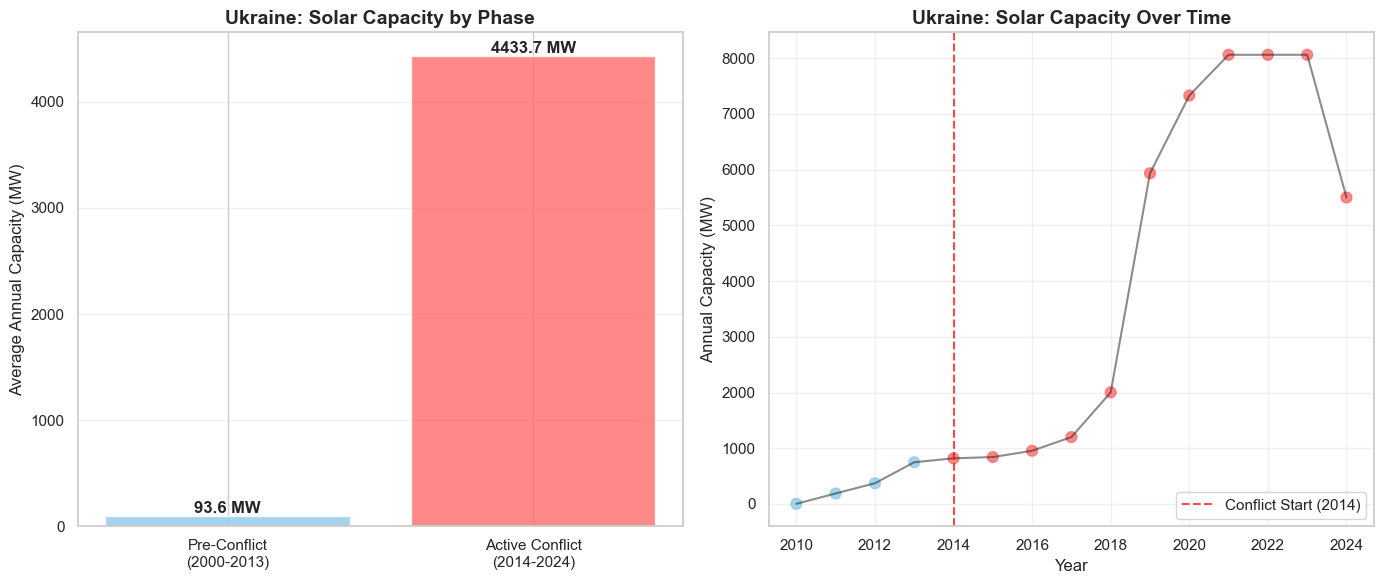


Ukraine Context:
  • Ukraine represents a unique case of ongoing conflict (2014-present)
  • Unlike other countries, Ukraine has no post-conflict period yet
  • This makes it distinct from countries with complete conflict cycles

Summary DataFrame shape: (8, 5)
Use 'summary_df' variable for further analysis


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Your conflict phase definitions
conflict_phases = {
    "Iraq": {
        "pre-conflict": range(2000, 2003),
        "active-conflict": range(2003, 2018),
        "post-conflict": range(2018, 2025),
    },
    "Afghanistan": {
        "pre-conflict": range(2000, 2001),
        "active-conflict": range(2001, 2022),
        "post-conflict": range(2022, 2025),
    },
    "Libya": {
        "pre-conflict": range(2000, 2011),
        "active-conflict": [2011] + list(range(2014, 2021)),
        "transitional": range(2012, 2014),
        "post-conflict": range(2021, 2025),
    },
    "Yemen": {
        "pre-conflict": range(2000, 2014),
        "active-conflict": range(2014, 2025),
    },
    "Ukraine": {
        "pre-conflict": range(2000, 2014),
        "active-conflict": range(2014, 2025),
    },
    "Ethiopia": {
        "pre-conflict": range(2000, 2020),
        "active-conflict": range(2020, 2023),
        "post-conflict": range(2023, 2025),
    },
    "South Sudan": {
        "pre-conflict": range(2000, 2012),
        "active-conflict": range(2013, 2021),
        "post-conflict": range(2021, 2025),
        "transitional": [2012],
    },
    "Sudan (the)": {
        "pre-conflict": range(2000, 2003),
        "active-conflict": list(range(2003, 2006))
        + list(range(2019, 2022))
        + list(range(2023, 2025)),
        "transitional": list(range(2006, 2019)) + [2022],
    },
    "Syrian Arab Republic (the)": {
        "pre-conflict": range(2000, 2011),
        "active-conflict": range(2011, 2025),
    },
}

# Filter to only solar type if needed
if "Type" in solar_df.columns:
    solar_df = solar_df[solar_df["Type"].str.lower() == "solar"]


# Calculate average capacity per year for each country and phase
def calculate_phase_averages(country_data, country_name):
    """Calculate average annual capacity for each phase of a country"""
    phases = conflict_phases[country_name]
    averages = {}

    for phase, years in phases.items():
        if isinstance(years, range):
            year_list = list(years)
        else:
            year_list = list(years)

        # Get data for this phase
        phase_data = country_data[country_data["Year"].isin(year_list)]

        if len(phase_data) > 0:
            # Calculate average annual capacity
            total_capacity = phase_data["Electricity Installed Capacity (MW)"].sum()
            num_years = len(year_list)
            averages[phase] = total_capacity / num_years
        else:
            averages[phase] = 0.0

    return averages


# Get available countries (exclude Ukraine from main analysis)
conflict_countries = list(conflict_phases.keys())
available_countries = [
    c
    for c in conflict_countries
    if c in solar_df["Country"].unique() and c != "Ukraine"
]

print("Solar Capacity Impact Analysis by Conflict Phase (Excluding Ukraine)")
print("=" * 70)
print(f"Analyzing {len(available_countries)} countries with solar data")
print()

# Create summary table data
summary_data = []

for country in available_countries:
    country_data = solar_df[solar_df["Country"] == country]

    if len(country_data) > 0:
        averages = calculate_phase_averages(country_data, country)

        # Get the three main phases
        pre_avg = averages.get("pre-conflict", 0)
        active_avg = averages.get("active-conflict", 0)
        post_avg = averages.get("post-conflict", 0)

        # Determine trend
        trend = "No Data"
        if pre_avg > 0 and active_avg > 0:
            if post_avg > 0:
                # All three phases available
                if active_avg < pre_avg * 0.7:  # 30% drop threshold
                    if post_avg > active_avg * 1.3:  # 30% recovery threshold
                        trend = "Recovery"
                    else:
                        trend = "Drop"
                elif active_avg > pre_avg * 1.3:  # 30% increase threshold
                    trend = "Increased"
                else:
                    trend = "Stable"
            else:
                # Only pre and active available
                if active_avg < pre_avg * 0.7:
                    trend = "Drop"
                elif active_avg > pre_avg * 1.3:
                    trend = "Increased"
                else:
                    trend = "Stable"
        elif active_avg > 0 and post_avg > 0:
            # Only active and post available
            if post_avg > active_avg * 1.3:
                trend = "Recovery"
            elif post_avg < active_avg * 0.7:
                trend = "Collapse"
            else:
                trend = "Stable"

        summary_data.append(
            {
                "Country": country,
                "Pre-Conflict Avg (MW)": pre_avg,
                "Conflict Avg (MW)": active_avg,
                "Post-Conflict Avg (MW)": post_avg,
                "Trend": trend,
            }
        )

# Create DataFrame for summary table
summary_df = pd.DataFrame(summary_data)

# Display the summary table
print("SUMMARY TABLE: Solar Capacity Impact by Conflict Phase")
print("=" * 60)
print(
    f"{'Country':<25} {'Pre-Conflict':<12} {'Conflict':<12} {'Post-Conflict':<12} {'Trend':<12}"
)
print("-" * 75)

for _, row in summary_df.iterrows():
    country_short = row["Country"][:24]  # Truncate long names
    print(
        f"{country_short:<25} {row['Pre-Conflict Avg (MW)']:<12.1f} {row['Conflict Avg (MW)']:<12.1f} {row['Post-Conflict Avg (MW)']:<12.1f} {row['Trend']:<12}"
    )

print()

# Categorize countries by trend
trend_categories = {
    "Drop": [],
    "Recovery": [],
    "Increased": [],
    "Stable": [],
    "Collapse": [],
}

for _, row in summary_df.iterrows():
    trend = row["Trend"]
    if trend in trend_categories:
        trend_categories[trend].append(row["Country"])

print("ANALYSIS BY TREND CATEGORY")
print("=" * 40)
for trend, countries in trend_categories.items():
    if countries:
        print(f"\n{trend.upper()} ({len(countries)} countries):")
        for country in countries:
            row = summary_df[summary_df["Country"] == country].iloc[0]
            print(
                f"  • {country}: {row['Pre-Conflict Avg (MW)']:.1f} → {row['Conflict Avg (MW)']:.1f} → {row['Post-Conflict Avg (MW)']:.1f} MW"
            )

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Bar chart comparing averages
countries_to_plot = summary_df["Country"].tolist()
pre_values = summary_df["Pre-Conflict Avg (MW)"].tolist()
conflict_values = summary_df["Conflict Avg (MW)"].tolist()
post_values = summary_df["Post-Conflict Avg (MW)"].tolist()

x = np.arange(len(countries_to_plot))
width = 0.25

bars1 = ax1.bar(
    x - width, pre_values, width, label="Pre-Conflict", color="#8ecae6", alpha=0.8
)
bars2 = ax1.bar(
    x, conflict_values, width, label="Active Conflict", color="#ff6b6b", alpha=0.8
)
bars3 = ax1.bar(
    x + width, post_values, width, label="Post-Conflict", color="#90be6d", alpha=0.8
)

ax1.set_title("Average Annual Solar Capacity by Phase", fontsize=14, fontweight="bold")
ax1.set_ylabel("Average Capacity (MW)")
ax1.set_xticks(x)
ax1.set_xticklabels(
    [c[:10] + "..." if len(c) > 10 else c for c in countries_to_plot], rotation=45
)
ax1.legend()
ax1.grid(True, alpha=0.3, axis="y")

# Plot 2: Trend distribution
trend_counts = summary_df["Trend"].value_counts()
colors = ["#ff6b6b", "#90be6d", "#ffd166", "#8ecae6", "#ff8fab"]
ax2.pie(
    trend_counts.values,
    labels=trend_counts.index,
    autopct="%1.1f%%",
    colors=colors[: len(trend_counts)],
)
ax2.set_title("Distribution of Conflict Impact Trends", fontsize=14, fontweight="bold")

# Plot 3: Scatter plot - Pre vs Conflict
ax3.scatter(
    pre_values,
    conflict_values,
    c=[
        colors[0] if t == "Drop" else colors[1] if t == "Recovery" else colors[2]
        for t in summary_df["Trend"]
    ],
    alpha=0.7,
    s=100,
)
ax3.plot(
    [0, max(pre_values)], [0, max(pre_values)], "k--", alpha=0.5, label="No Change Line"
)
ax3.set_xlabel("Pre-Conflict Avg (MW)")
ax3.set_ylabel("Conflict Avg (MW)")
ax3.set_title("Pre-Conflict vs Conflict Period", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3)

# Add country labels to scatter plot
for i, country in enumerate(countries_to_plot):
    ax3.annotate(
        country[:8],
        (pre_values[i], conflict_values[i]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
    )

# Plot 4: Change patterns
for i, country in enumerate(countries_to_plot):
    phases = ["Pre", "Conflict", "Post"]
    values = [pre_values[i], conflict_values[i], post_values[i]]

    # Only plot if we have data
    valid_indices = [j for j, v in enumerate(values) if v > 0]
    if len(valid_indices) > 1:
        valid_phases = [phases[j] for j in valid_indices]
        valid_values = [values[j] for j in valid_indices]

        ax4.plot(valid_phases, valid_values, "o-", alpha=0.7, label=country[:8])

ax4.set_title("Individual Country Trajectories", fontsize=14, fontweight="bold")
ax4.set_ylabel("Average Capacity (MW)")
ax4.grid(True, alpha=0.3)
ax4.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

plt.tight_layout()
plt.show()

# Separate analysis for Ukraine
print("\n" + "=" * 70)
print("SEPARATE ANALYSIS: UKRAINE")
print("=" * 70)

ukraine_data = solar_df[solar_df["Country"] == "Ukraine"]
if len(ukraine_data) > 0:
    ukraine_averages = calculate_phase_averages(ukraine_data, "Ukraine")

    ukraine_pre = ukraine_averages.get("pre-conflict", 0)
    ukraine_active = ukraine_averages.get("active-conflict", 0)

    # Ukraine only has pre-conflict and active-conflict phases
    print(f"Ukraine Solar Capacity Analysis:")
    print(f"  Pre-Conflict (2000-2013): {ukraine_pre:.1f} MW average annually")
    print(f"  Active Conflict (2014-2024): {ukraine_active:.1f} MW average annually")

    if ukraine_pre > 0 and ukraine_active > 0:
        change_pct = ((ukraine_active - ukraine_pre) / ukraine_pre) * 100
        print(f"  Change during conflict: {change_pct:+.1f}%")

        if change_pct > 30:
            ukraine_trend = "INCREASED - Remarkable growth despite ongoing conflict"
        elif change_pct < -30:
            ukraine_trend = "DROPPED - Significant decline during conflict"
        else:
            ukraine_trend = "STABLE - Minimal change during conflict"
    else:
        ukraine_trend = "INSUFFICIENT DATA"

    print(f"  Trend: {ukraine_trend}")

    # Create Ukraine-specific visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Bar chart for Ukraine
    phases = ["Pre-Conflict\n(2000-2013)", "Active Conflict\n(2014-2024)"]
    values = [ukraine_pre, ukraine_active]
    colors = ["#8ecae6", "#ff6b6b"]

    bars = ax1.bar(phases, values, color=colors, alpha=0.8)
    ax1.set_title("Ukraine: Solar Capacity by Phase", fontsize=14, fontweight="bold")
    ax1.set_ylabel("Average Annual Capacity (MW)")
    ax1.grid(True, alpha=0.3, axis="y")

    # Add value labels
    for bar, val in zip(bars, values):
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{val:.1f} MW",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # Time series plot for Ukraine
    ukraine_yearly = ukraine_data.groupby("Year")[
        "Electricity Installed Capacity (MW)"
    ].sum()
    years = ukraine_yearly.index
    capacities = ukraine_yearly.values

    # Color points by phase
    colors_by_year = []
    for year in years:
        if year in conflict_phases["Ukraine"]["pre-conflict"]:
            colors_by_year.append("#8ecae6")
        elif year in conflict_phases["Ukraine"]["active-conflict"]:
            colors_by_year.append("#ff6b6b")
        else:
            colors_by_year.append("gray")

    ax2.scatter(years, capacities, c=colors_by_year, s=60, alpha=0.8)
    ax2.plot(years, capacities, "k-", alpha=0.5)

    # Add vertical line at conflict start
    ax2.axvline(
        x=2014, color="red", linestyle="--", alpha=0.7, label="Conflict Start (2014)"
    )

    ax2.set_title("Ukraine: Solar Capacity Over Time", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Annual Capacity (MW)")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nUkraine Context:")
    print(f"  • Ukraine represents a unique case of ongoing conflict (2014-present)")
    print(f"  • Unlike other countries, Ukraine has no post-conflict period yet")
    print(f"  • This makes it distinct from countries with complete conflict cycles")

else:
    print("No Ukraine solar data found in the dataset")

# Export summary table as DataFrame for further analysis
print(f"\nSummary DataFrame shape: {summary_df.shape}")
print("Use 'summary_df' variable for further analysis")


Regression Coefficient: 1359.32
Intercept: 568.99
✅ Conflict periods show a positive effect on growth in solar capacity.


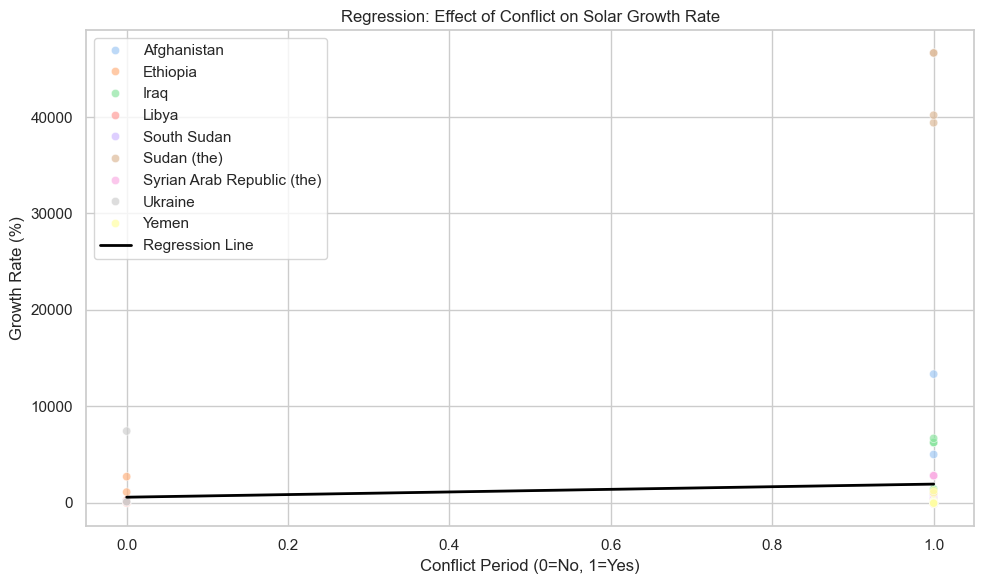

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Filter only solar energy from Total Renewable
solar_df = df[
    df["RE or Non-RE"].str.contains("Total Renewable", case=False, na=False)
    & df["Group Technology"].str.contains("Solar energy", case=False, na=False)
].copy()

# 2. Make sure relevant columns are numeric
solar_df["Electricity Installed Capacity (MW)"] = pd.to_numeric(
    solar_df["Electricity Installed Capacity (MW)"], errors="coerce"
)

# 3. Sort to calculate year-on-year growth per country
solar_df = solar_df.sort_values(by=["Country", "Year"])

# 4. Compute growth rate (% change from previous year)
solar_df["Growth Rate (%)"] = (
    solar_df.groupby("Country")["Electricity Installed Capacity (MW)"].pct_change()
    * 100
)

# 5. Drop missing values in Growth Rate
solar_df = solar_df.dropna(subset=["Growth Rate (%)"])

# 6. Define active + post conflict as conflict period
solar_df["Conflict"] = solar_df["Conflict Phase"].apply(
    lambda x: 1 if str(x).lower() in ["active-conflict", "post-conflict"] else 0
)

# 7. Simple Regression: Does being in a conflict period affect growth rate?
X = solar_df[["Conflict"]]
y = solar_df["Growth Rate (%)"]

model = LinearRegression()
model.fit(X, y)
solar_df["Predicted Growth"] = model.predict(X)

# 8. Print regression coefficient and interpretation
coef = model.coef_[0]
intercept = model.intercept_

print("Regression Coefficient:", round(coef, 2))
print("Intercept:", round(intercept, 2))

if coef < 0:
    print(
        "⚠️ During conflict periods (active+post), growth in solar capacity decreases on average."
    )
elif coef > 0:
    print("✅ Conflict periods show a positive effect on growth in solar capacity.")
else:
    print("➖ Conflict periods show no measurable effect on solar growth rate.")

# 9. Optional: Plot actual vs predicted growth (for interpretation)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=solar_df, x="Conflict", y="Growth Rate (%)", hue="Country", alpha=0.7
)
sns.lineplot(
    data=solar_df,
    x="Conflict",
    y="Predicted Growth",
    color="black",
    linewidth=2,
    label="Regression Line",
)
plt.title("Regression: Effect of Conflict on Solar Growth Rate")
plt.xlabel("Conflict Period (0=No, 1=Yes)")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
